# Einasto and Hernquist Benchmarks 

This notebook generates benchmarks for Einasto and Hernquist density profiles (and lensing quantities) from NumCosmo.

In [1]:
import numpy as np
import math

In [2]:
# For NumCosmo
import gi
gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [3]:
import sys
import os

os.environ['CLMM_MODELING_BACKEND'] = 'ccl'

from clmm import theory as pp

## Configuration

### Cosmology

In [4]:
# If CCL is installed, define a CCL cosmology object
# import pyccl as ccl
# cosmo_ccl = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# If CCL is not installed, use astropy instead with the following lines
#from astropy.cosmology import FlatLambdaCDM
#astropy_cosmology_object = FlatLambdaCDM(H0=67.66, Odm0=0.262, Ob0=0.049)
#cosmo_ccl = pp.cclify_astropy_cosmo(astropy_cosmology_object)

cosmo_ccl = pp.Cosmology (H0 = 67.66, Omega_dm0 = 0.262, Omega_b0 = 0.049)

cosmo_ccl.be_cosmo

print (cosmo_ccl['Omega_m0'], 0.262+0.049)

0.31240715689016263 0.311


### Cluster/source config

In [5]:
# Select density profile and profile parametrization options
density_profile_parametrization = 'einasto'
mass_Delta            = 200    # Mass defintion: mean matter density
cluster_mass          = 1.0e15 # Msun
cluster_concentration = 4.0
z_max                 = 3.0
z_cluster             = 1.0
z_source              = 2.0

### Vectors for inputs

In [16]:
z_a = np.linspace (0.01, 10.0, 1000)
a_a = 1.0 / (1.0 + z_a)
r3d = np.logspace (-2, 2, 100)

### NumCosmo
Pass configs to `NumCosmo`

In [24]:
#########################
# Initializing NumCosmo #
#########################
Ncm.cfg_init ()

##################
# Set Cosmology ##
##################
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<1>}")
cosmo.omega_x2omega_k ()

cosmo.props.w  = -1.0
cosmo.props.H0 = cosmo_ccl['H0']

cosmo.param_set_by_name ("H0",     cosmo_ccl['H0'])
cosmo.param_set_by_name ("Omegab", cosmo_ccl['Omega_b0'])
cosmo.param_set_by_name ("Omegac", cosmo_ccl['Omega_dm0'])
cosmo.param_set_by_name ("w",      -1.0)
cosmo.param_set_by_name ("Omegak",  0.0)
cosmo.param_set_by_name ("Tgamma0", 2.7255)
cosmo.param_set_by_name ("massnu_0", 0.06)
#cosmo_nc.param_set_by_name ("Tnu_0",    (4.0/11.0)**(1.0/3.0))
#cosmo_nc.param_set_by_name ("gnu_0",    1.0153080198436308)
cosmo.param_set_by_name ("ENnu", 3.046 - 3.0 * cosmo.E2Press_mnu (1.0e10) / (cosmo.E2Omega_g (1.0e10) * (7.0/8.0*(4.0/11.0)**(4.0/3.0))))

import pyccl as ccl

z = 10.0
A = ccl.background.omega_x (cosmo_ccl.be_cosmo, 1.0 / (1.0 + z), 'matter')
B = cosmo.E2Omega_m(z)/cosmo.E2(z)

print (A/B - 1.0)
print (cosmo.Omega_m0()/cosmo_ccl['Omega_m0'] - 1.0)


5.473165719149797e-05
-3.044553118503046e-07


In [25]:
##########################
# Config Cluster/Source ##
##########################

# NumCosmo Density profile

reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True
log10Mmean = math.log10(cluster_mass)

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
nc_ein.param_set_by_name ('cDelta', cluster_concentration) 
nc_ein.param_set_by_name ('log10MDelta', log10Mmean)
nc_ein.param_set_by_name ('alpha', 0.3675918420028502) 
# CCL value (alpha(nu)) given the current cosmological model, cluster mass and redshift

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
nc_her.param_set_by_name ('cDelta', cluster_concentration) 
nc_her.param_set_by_name ('log10MDelta', log10Mmean) 

if improve_prec:
    nc_her.set_reltol (reltol) 
    nc_her.set_lnXi (lnXi)
    nc_her.set_lnXf (lnXf)


dist = Nc.Distance.new (z_max)
smd  = Nc.WLSurfaceMassDensity.new (dist)

smd.prepare (cosmo)


## Comparisons

### Function to make automatic comparisons

In [26]:
import pylab as plt
def compare(x, y_clmm, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(6, 4)}):
    clmm_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    diff = y_nc/y_clmm - 1.
    print('rel diff min: %g\nrel diff max: %g'%(min(abs(diff)), max(abs(diff))))
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    
    axs[0].plot(x, y_clmm, label='clmm', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    axs[1].plot(x, diff, c='r')
    axs[1].axhline(0, ls=':', c='0', lw=.5)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, clmm_name))
    
    return fig, axs

### Quick test of all theory function

rel diff min: 2.56087e-10
rel diff max: 6.37375e-07


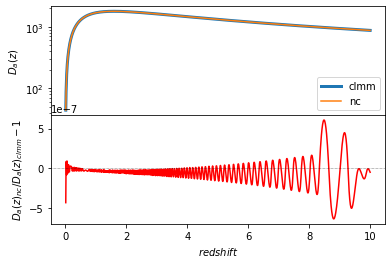

In [27]:
Da_a    = cosmo_ccl.eval_da_a1a2(a_a)
nc_Da_a = np.array ([dist.angular_diameter (cosmo, z) * cosmo.RH_Mpc () for z in  z_a])

fig, axs = compare (z_a, Da_a, nc_Da_a, x_name='redshift', y_name='D_a(z)')
axs[0].set_yscale ('log')


rel diff min: 0.00789776
rel diff max: 1


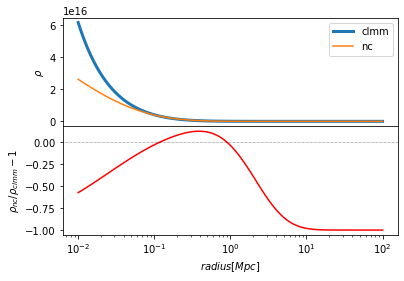

In [32]:
# for now we cannot choose einasto for CCL backend
rho    = pp.compute_3d_density (r3d, mdelta = cluster_mass, cdelta = cluster_concentration,
                            z_cl = z_cluster, cosmo = cosmo_ccl, delta_mdef = mass_Delta, halo_profile_model='nfw')
nc_rho_ein = np.array ([nc_ein.eval_density (cosmo, r3d_i, z_cluster) for r3d_i in r3d])

fig, axs = compare(r3d, rho_ein, nc_rho_ein, x_name='radius [Mpc]', y_name='\\rho')
axs[0].set_xscale('log')

### Einasto: lensing quantities

In [33]:
nc_Sigmac = smd.sigma_critical (cosmo, z_source, z_cluster, z_cluster)

nc_Sigma_ein = np.array ([smd.sigma (nc_ein, cosmo, r3d_i, z_cluster) for r3d_i in r3d])
nc_SigmaMean_ein  = np.array ([smd.sigma_mean (nc_ein, cosmo, r3d_i, z_cluster) for r3d_i in r3d])
nc_DeltaSigma_ein = nc_SigmaMean_ein - nc_Sigma_ein
nc_gammat_ein = np.array ([smd.shear (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])
nc_kappa_ein = np.array ([smd.convergence (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])
nc_gt_ein = np.array ([smd.reduced_shear (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])
nc_mu_ein = np.array ([smd.magnification (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])

### Hernquist: 3D density and lensing quantities

In [34]:
nc_rho_her = np.array ([nc_ein.eval_density (cosmo, r3d_i, z_cluster) for r3d_i in r3d])
nc_Sigma_her = np.array ([smd.sigma (nc_ein, cosmo, r3d_i, z_cluster) for r3d_i in r3d])
nc_SigmaMean_her  = np.array ([smd.sigma_mean (nc_ein, cosmo, r3d_i, z_cluster) for r3d_i in r3d])
nc_DeltaSigma_her = nc_SigmaMean_her - nc_Sigma_her
nc_gammat_her = np.array ([smd.shear (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])
nc_kappa_her = np.array ([smd.convergence (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])
nc_gt_her = np.array ([smd.reduced_shear (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])
nc_mu_her = np.array ([smd.magnification (nc_ein, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])

### Save the numcosmo outputs 

In [35]:
np.savetxt('radial_profiles_einasto.txt',
           np.array([r3d,  nc_rho_ein, nc_Sigma_ein, nc_DeltaSigma_ein, nc_gammat_ein, nc_kappa_ein, nc_gt_ein, nc_mu_ein]).T,
           header='r3d  rho Sigma DeltaSigma gammat kappa gt mu')

In [36]:
np.savetxt('radial_profiles_hernquist.txt',
           np.array([r3d,  nc_rho_her, nc_Sigma_her, nc_DeltaSigma_her, nc_gammat_her, nc_kappa_her, nc_gt_her, nc_mu_her]).T,
           header='r3d  rho Sigma DeltaSigma gammat kappa gt mu')

In [37]:
config_dict = {'dl': dist.angular_diameter (cosmo, z_cluster) * cosmo.RH_Mpc (),
               'z_source': z_source,
               'cluster_mass': cluster_mass,
               'G[m3/km.s2]': Ncm.C.G(),
               'aexp_cluster': 1./(1.+z_cluster),
               'density_profile_parametrization': density_profile_parametrization,
               'ds': dist.angular_diameter (cosmo, z_source) * cosmo.RH_Mpc (),
               'cosmo_Ob0': cosmo_ccl['Omega_b0'],
               'aexp_source': 1./(1.+z_source),
               'dsl': dist.angular_diameter_z1_z2 (cosmo, z_cluster, z_source) * cosmo.RH_Mpc (),
               'z_cluster': z_cluster,
               'mass_Delta': mass_Delta,
               'lightspeed[km/s]': Ncm.C.c()/1000.,
               'cosmo_H0': cosmo_ccl['H0'],
               'cluster_concentration': cluster_concentration,
               'cosmo_Om0': cosmo_ccl['Omega_m0'],
               'cosmo_Odm0': cosmo_ccl['Omega_dm0'],
               'nc_Sigmac': nc_Sigmac,
               'Msun[kg]': Ncm.C.mass_solar(),
               'pc_to_m': Ncm.C.pc()}

import json
with open('config_einasto_henrquist_benchmarks.json', 'w') as fp:
    json.dump(config_dict, fp)